# Notebook used for testing functions developed in the iib-neuro-proj library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from gen_inputs import *
from functs_inputs import *
from sim_hLN import *

### Generate some 'realisitc' inputs

[15.  0.  0. 14. 15.  0. 12. 14. 14.  0. 14.  0.  0.  0.  3.  2.]
orientation 0 finished
orientation 1 finished
orientation 2 finished
orientation 3 finished
orientation 4 finished
orientation 5 finished
orientation 6 finished
orientation 7 finished
orientation 8 finished
orientation 9 finished
orientation 10 finished
orientation 11 finished
orientation 12 finished
orientation 13 finished
orientation 14 finished
orientation 15 finished
Excitatory spikes shape: (184093, 2) Inhibitory spikes shape: (544858, 2)


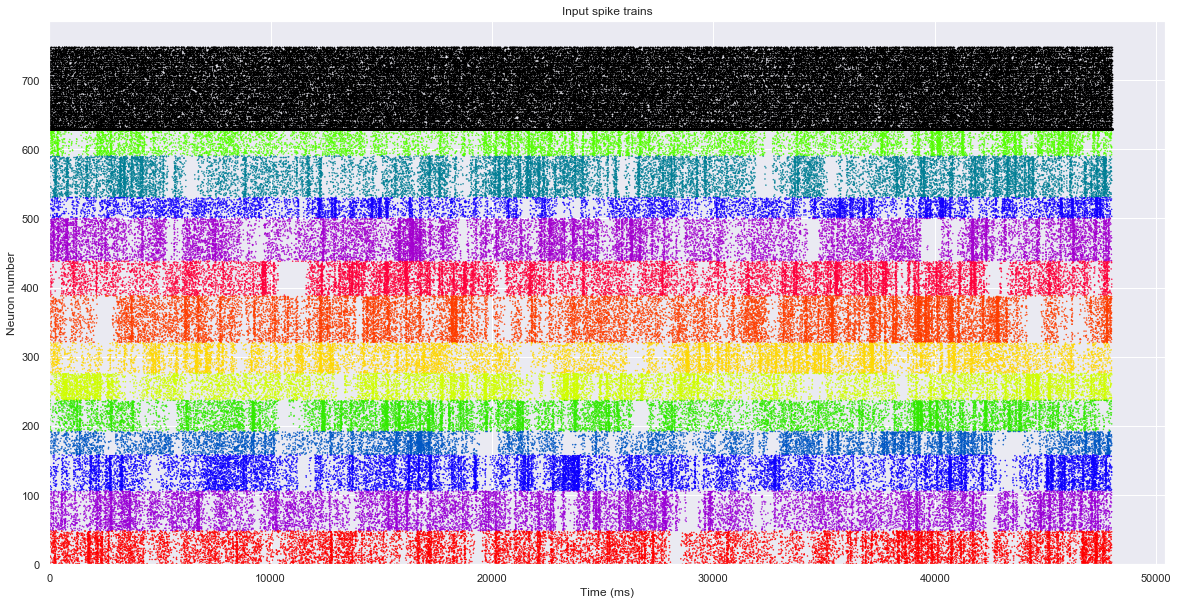

In [2]:
E_spikes, I_spikes = gen_realistic_inputs(Tmax=3000)
print("Excitatory spikes shape:", E_spikes.shape, "Inhibitory spikes shape:", I_spikes.shape)

Ensyn = [48, 58, 52, 34, 45, 39, 44, 68, 50, 62, 30, 60, 39]
Ensyn_cum = np.cumsum(Ensyn)
Ensyn_cum = Ensyn_cum.reshape(13, 1)
ens_num = np.argmax(Ensyn_cum > E_spikes[:, 0] - 1, axis=0)

plt.figure(figsize=(20,10))
plt.scatter(E_spikes[:, 1], E_spikes[:, 0], s=1, c=ens_num, cmap="prism", marker='.', label="Excitatory")
plt.scatter(I_spikes[:, 1], np.sum(Ensyn) + I_spikes[:, 0], s=1, marker='.', color='black', label='Inhibitory')
plt.xlabel("Time (ms)")
plt.ylabel("Neuron number")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.title("Input spike trains")
plt.show()

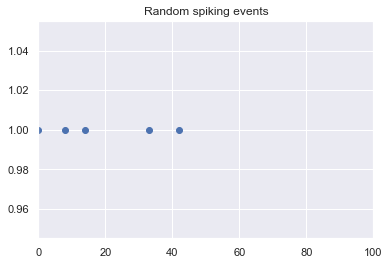

In [3]:
N = 100 # number of time bins
samp = binary_input(1, N, kind='rand')
times = np.arange(0, N, 1)
spikes = np.where(samp==0, np.nan, samp)
plt.plot(times, spikes.T, 'o')
plt.title("Random spiking events")
plt.xlim(0, N)
plt.show()

(1, 100)


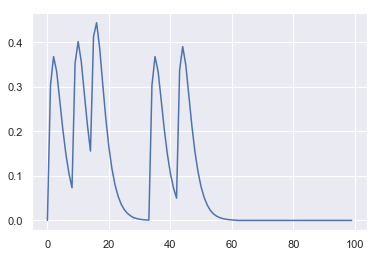

In [4]:
# show alpha filt works
conv = alpha_filt(tau=2, spikes=samp)
print(conv.shape)
plt.plot(times, conv.T)
plt.show()

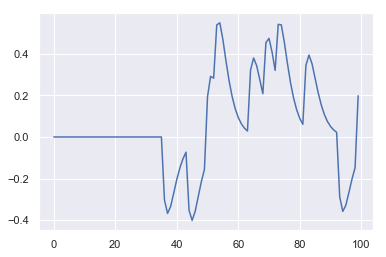

(100,)


In [5]:
# show int_spikes works
samp_2d = binary_input(2, N, kind='rand')
conv_int = int_spikes(X=samp_2d, dt=1, Wc=[0, 1], Ww=[1, -1], Tau=2, delay=0)
plt.plot(times, conv_int.T)
plt.show()
print(conv_int.shape)

In [6]:
# input realistic inputs to model
X_e = spikes_to_input(E_spikes, Tmax=48000)
X_i = spikes_to_input(I_spikes, Tmax=48000)
X_tot = np.vstack((X_e, X_i))

# number of excitatory, inhibitory neurons by ensemble
Ensyn = [48, 58, 52, 34, 45, 39, 44, 68, 50, 62, 30, 60, 39]
Insyn = [11, 11, 9, 6, 8, 5, 8, 12, 11, 13, 6, 11, 8]

N_e, N_i = np.sum(Ensyn), np.sum(Insyn)
N_soma = N_e + 1 #index of soma row in X_tot - might want to weight these inputs differently

# these parameters for 1 subunit
Jc_sing = np.array([0])
M = len(Jc_sing) #number of subunits
Wce_sing = [np.arange(0, X_e.shape[0], 1)] #all input excitatory neurons connected to root subunit
Wwe_sing = [np.ones(X_e.shape[0])] #weighting matrix - all excitatory neurons connected with weight 1 
Wci_sing = [np.arange(N_soma, N_soma + X_i.shape[0] -1, 1)] #all input inhibitory neurons connected to root subunit
Wwi_sing = [np.full(X_i.shape[0], -1)] #weighting matrix - all inhibitory neurons connected with weight -1
Tau_e = [np.full(X_e.shape[0], 1)] #all excitatory time constants 1
Tau_i = [np.full(X_i.shape[0], 1)] #all inhibitory time constants 1
Th = [0] #no offset in all sigmoids



resp_sing = sim_hLN(X=X_tot, dt=1, Jc=Jc_sing, Wce=Wce_sing, Wwe=Wwe_sing, Wci=Wci_sing, Wwi=Wwi_sing, Tau_e=Tau_e, Tau_i=Tau_i, Th=Th, mult_inputs=True)





[1.]


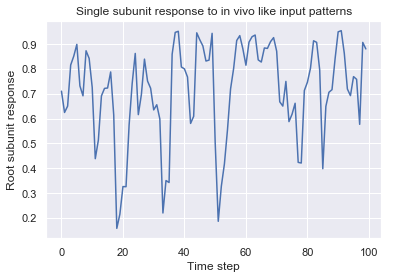

In [7]:
plt.plot(resp_sing[4900:5000])
plt.title("Single subunit response to in vivo like input patterns")
plt.xlabel("Time step")
plt.ylabel("Root subunit response")
plt.show()

In [8]:
# now parameters for 2 layer, 3 subunit model 
# all excitatory inputs to 1 subunit, all inhibitory to other unit in outer layer, then combine at root subunit 
Jc_2 = np.array([0, 1, 1])
M_2 = len(Jc_sing) #number of subunits


Wce_2 = [[], np.arange(0, X_e.shape[0], 1), []] #all input excitatory neurons connected to subunit 2
Wwe_2 = [[], np.ones(X_e.shape[0]), []] #weighting matrix - all excitatory neurons connected with weight 1 
Wci_2 = [[], [], np.arange(N_soma, N_soma + X_i.shape[0] -1, 1)] #all input inhibitory neurons connected to subunit 3
Wwi_2 = [[], [], np.full(X_i.shape[0], -1)] #weighting matrix - all inhibitory neurons connected with weight -1
Tau_e2 = [[], np.full(X_e.shape[0], 1), []] #all excitatory time constants 1
Tau_i2 = [[], [], np.full(X_i.shape[0], 1)] #all inhibitory time constants 1
Th_2 = [1, 0, 0] #no offset in all sigmoids

resp_2 = sim_hLN(X=X_tot, dt=1, Jc=Jc_2, Wce=Wce_2, Wwe=Wwe_2, Wci=Wci_2, Wwi=Wwi_2, Tau_e=Tau_e2, Tau_i=Tau_i2, Th=Th_2, mult_inputs=True)


[2.]
[2. 3.]
[2. 3. 1.]


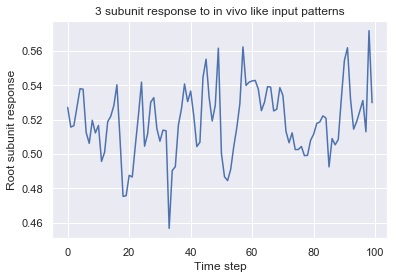

In [9]:
plt.plot(resp_2[4900:5000])
plt.title("3 subunit response to in vivo like input patterns")
plt.xlabel("Time step")
plt.ylabel("Root subunit response")
plt.show()